# Language Agent Tree Search

[Language Agent Tree Search](https://arxiv.org/abs/2310.04406) (LATS), by Zhou, et. al, is a general LLM agent search algorithm that combines reflection/evaluation and search (specifically monte-carlo trees search) to get achieve better overall task performance compared to similar techniques like ReACT, Reflexion, or Tree of Thoughts.

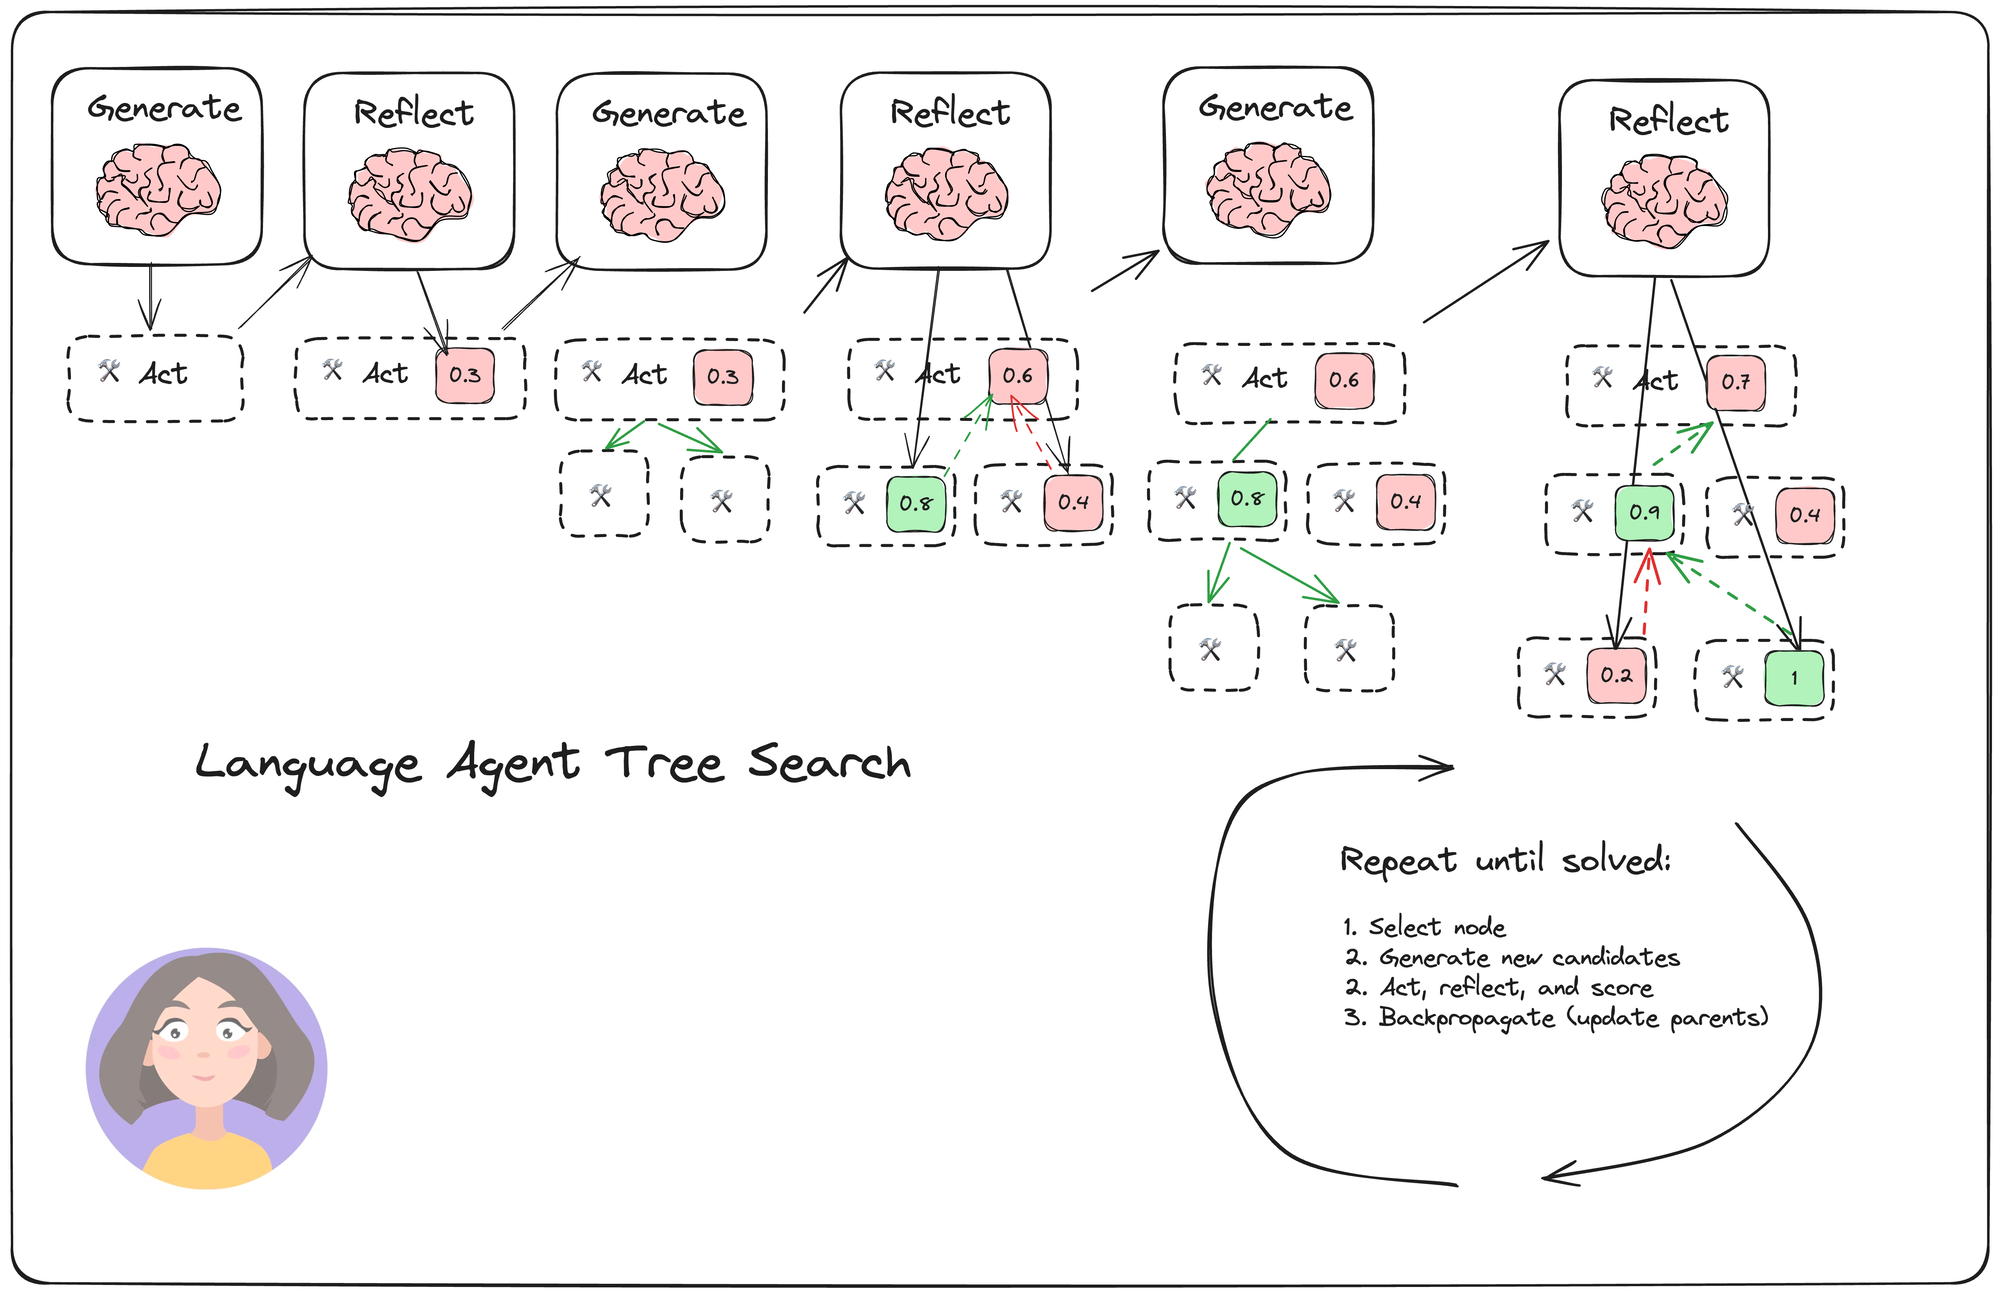

It has four main steps:

1. Select: pick the best next actions based on the aggregate rewards from step (2). Either respond (if a solution is found or the max search depth is reached) or continue searching.
2. Expand and simulate: select the "best" 5 potential actions to take and execute them in parallel.
3. Reflect + Evaluate: observe the outcomes of these actions and score the decisions based on reflection (and possibly external feedback)
4. Backpropagate: update the scores of the root trajectories based on the outcomes.

## Setup

Install `langgraph` (for the framework), `langchain_openai` (for the LLM), and `langchain` + `tavily-python` (for the search engine).

We will use tavily search as a tool. You can get an API key [here](https://app.tavily.com/sign-in) or replace with a different tool of your choosing.

In [ ]:
%%capture --no-stderr
%pip install -U --quiet langchain langgraph langchain_openai
%pip install -U --quiet tavily-python

In [1]:
import getpass
import os


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>   

## Graph State

LATS is based on a  (greedy) Monte-Carlo tree search. For each search steps, it picks the node with the highest "upper confidence bound", which is a metric that balances exploitation (highest average reward) and exploration (lowest visits). Starting from that node, it generates N (5 in this case) new candidate actions to take, and adds them to the tree. It stops searching either when it has generated a valid solution OR when it has reached the maximum number of rollouts (search tree depth).

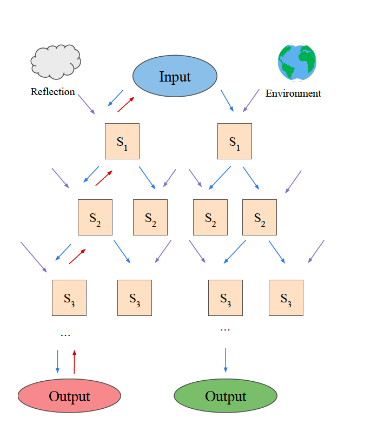

Our LangGraph state will be composed of two items:
1. The root of the search tree
2. The user input

In [4]:
import math
from collections import deque
from typing import Optional

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

from pydantic import BaseModel, Field


class Reflection(BaseModel):
    reflections: str = Field(
        description="The critique and reflections on the sufficiency, superfluency,"
        " and general quality of the response"
    )
    score: int = Field(
        description="Score from 0-10 on the quality of the candidate response.",
        gte=0,
        lte=10,
    )
    found_solution: bool = Field(
        description="Whether the response has fully solved the question or task."
    )

    def as_message(self):
        return HumanMessage(
            content=f"Reasoning: {self.reflections}\nScore: {self.score}"
        )

    @property
    def normalized_score(self) -> float:
        return self.score / 10.0

class Node:
    def __init__(
        self,
        messages: list[BaseMessage],
        reflection: Reflection,
        parent: Optional["Node"] = None,
    ):
        self.messages = messages
        self.parent = parent
        self.children = []
        self.value = 0
        self.visits = 0
        self.reflection = reflection
        self.depth = parent.depth + 1 if parent is not None else 1
        self._is_solved = reflection.found_solution if reflection else False
        if self._is_solved:
            self._mark_tree_as_solved()
        self.backpropagate(reflection.normalized_score)

    def __repr__(self) -> str:
        return (
            f"<Node value={self.value}, visits={self.visits},"
            f" solution={self.messages} reflection={self.reflection}/>"
        )

    @property
    def is_solved(self):
        """If any solutions exist, we can end the search."""
        return self._is_solved

    @property
    def is_terminal(self):
        return not self.children

    @property
    def best_child_score(self):
        """Return the child with the highest value."""
        if not self.children:
            return None
        return max(self.children, key=lambda child: int(child.is_solved) * child.value)

    @property
    def height(self) -> int:
        """Check for how far we've rolled out the tree."""
        if self.children:
            return 1 + max([child.height for child in self.children])
        return 1

    def upper_confidence_bound(self, exploration_weight=1.0):
        """Return the UCT score. This helps balance exploration vs. exploitation of a branch."""
        if self.parent is None:
            raise ValueError("Cannot obtain UCT from root node")
        if self.visits == 0:
            return self.value
        # Encourages exploitation of high-value trajectories
        average_reward = self.value / self.visits
        # Encourages exploration of less-visited trajectories
        exploration_term = math.sqrt(math.log(self.parent.visits) / self.visits)
        return average_reward + exploration_weight * exploration_term

    def backpropagate(self, reward: float):
        """Update the score of this node and its parents."""
        node = self
        while node:
            node.visits += 1
            node.value = (node.value * (node.visits - 1) + reward) / node.visits
            node = node.parent

    def get_messages(self, include_reflections: bool = True):
        if include_reflections:
            return self.messages + [self.reflection.as_message()]
        return self.messages

    def get_trajectory(self, include_reflections: bool = True) -> list[BaseMessage]:
        """Get messages representing this search branch."""
        messages = []
        node = self
        while node:
            messages.extend(
                node.get_messages(include_reflections=include_reflections)[::-1]
            )
            node = node.parent
        # Reverse the final back-tracked trajectory to return in the correct order
        return messages[::-1]  # root solution, reflection, child 1, ...

    def _get_all_children(self):
        all_nodes = []
        nodes = deque()
        nodes.append(self)
        while nodes:
            node = nodes.popleft()
            all_nodes.extend(node.children)
            for n in node.children:
                nodes.append(n)
        return all_nodes

    def get_best_solution(self):
        """Return the best solution from within the current sub-tree."""
        all_nodes = [self] + self._get_all_children()
        best_node = max(
            all_nodes,
            # We filter out all non-terminal, non-solution trajectories
            key=lambda node: int(node.is_terminal and node.is_solved) * node.value,
        )
        return best_node

    def _mark_tree_as_solved(self):
        parent = self.parent
        while parent:
            parent._is_solved = True
            parent = parent.parent

#### The graph state itself

The main component is the tree, represented by the root node.

In [5]:
from typing_extensions import TypedDict


class TreeState(TypedDict):
    # The full tree
    root: Node
    # The original input
    input: str

## Define Language Agent

Our agent will have three primary LLM-powered processes:
1. Reflect: score the action based on the tool response.
2. Initial response: to create the root node and start the search.
3. Expand: generate 5 candidate "next steps" from the best spot in the current tree

For more "Grounded" tool applications (such as code synthesis), you could integrate code execution into the reflection/reward step. This type of external feedback is very useful (though adds complexity to an already complicated example notebook).

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

#### Tools

For our example, we will give the language agent a search engine.

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_executor = ToolExecutor(tools=tools)

/var/folders/td/vzm913rx77x21csd90g63_7c0000gn/T/ipykernel_4902/4209779393.py:9: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools=tools)


### Reflection

The reflection chain will score agent outputs based on the decision and the tool responses.
We will call this within the other two nodes.

In [8]:
from langchain_core.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Reflect and grade the assistant response to the user question below.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="candidate"),
    ]
)

reflection_llm_chain = (
    prompt
    | llm.bind_tools(tools=[Reflection], tool_choice="Reflection").with_config(
        run_name="Reflection"
    )
    | PydanticToolsParser(tools=[Reflection])
)


@as_runnable
def reflection_chain(inputs) -> Reflection:
    tool_choices = reflection_llm_chain.invoke(inputs)
    reflection = tool_choices[0]
    if not isinstance(inputs["candidate"][-1], AIMessage):
        reflection.found_solution = False
    return reflection

### Initial Response

We start with a single root node, generated by this first step. It responds to the user input either with a tool invocation or a response.

In [9]:
from langchain_core.prompt_values import ChatPromptValue
from langchain_core.runnables import RunnableConfig

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


initial_answer_chain = prompt_template | llm.bind_tools(tools=tools).with_config(
    run_name="GenerateInitialCandidate"
)


parser = JsonOutputToolsParser(return_id=True)

In [10]:
initial_response = initial_answer_chain.invoke(
    {"input": "Write a research report on lithium pollution."}
)
initial_response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mljwYuqZwfWNjUKnatTCC0zI', 'function': {'arguments': '{"query": "lithium pollution research report 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_EYJv1yTvnPoymBcqmbQqoUJG', 'function': {'arguments': '{"query": "lithium mining environmental impact 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_o4vzIZsAeGXQyJPaGRxsSIk3', 'function': {'arguments': '{"query": "lithium battery disposal environmental effects 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 95, 'prompt_tokens': 93, 'total_tokens': 188, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_992d1ea92d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7924bc82-258a-4f1b-8c9b-87f7512eec7c-0', tool_calls=[{'name': 'tavily_search_r

#### Starting Node

We will package up the candidate generation and reflection in a single node of our graph. This is represented by the following function:

In [11]:
import json


# Define the node we will add to the graph
def generate_initial_response(state: TreeState) -> dict:
    """Generate the initial candidate response."""
    res = initial_answer_chain.invoke({"input": state["input"]})
    parsed = parser.invoke(res)
    tool_responses = tool_executor.batch(
        [ToolInvocation(tool=r["type"], tool_input=r["args"]) for r in parsed]
    )
    output_messages = [res] + [
        ToolMessage(content=json.dumps(resp), tool_call_id=tool_call["id"])
        for resp, tool_call in zip(tool_responses, parsed)
    ]
    reflection = reflection_chain.invoke(
        {"input": state["input"], "candidate": output_messages}
    )
    root = Node(output_messages, reflection=reflection)
    return {
        **state,
        "root": root,
    }

### Candidate Generation

The following code prompts the same LLM to generate N additional candidates to check.

In [12]:
# This generates N candidate values
# for a single input to sample actions from the environment


def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):
    n = config["configurable"].get("N", 5)
    bound_kwargs = llm.bind_tools(tools=tools).kwargs
    chat_result = llm.generate(
        [messages.to_messages()],
        n=n,
        callbacks=config["callbacks"],
        run_name="GenerateCandidates",
        **bound_kwargs,
    )
    return [gen.message for gen in chat_result.generations[0]]


expansion_chain = prompt_template | generate_candidates

In [13]:
res = expansion_chain.invoke({"input": "Write a research report on lithium pollution."})
res

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_z2POWhKzUjyEJzAMPhT9OkaY', 'function': {'arguments': '{"query":"lithium pollution research report 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f5d36271-77a1-49f4-b57b-914baa04e3e1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'lithium pollution research report 2023'}, 'id': 'call_z2POWhKzUjyEJzAMPhT9OkaY', 'type': 'tool_call'}], usage_metadata={'input_tokens': 93, 'output_tokens': 123, 'total_tokens': 216}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_z2POWhKzUjyEJzAMPhT9OkaY', 'function': {'arguments': '{"query":"lithium pollution research 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f5d36271-77a1-49f4-b57b-914baa04e3e1-1', tool_calls=[{'name': 

#### Candidate generation node

We will package the candidate generation and reflection steps in the following "expand" node.
We do all the operations as a batch process to speed up execution.

In [14]:
from collections import defaultdict

def select(root: Node) -> dict:
    """Starting from the root node a child node is selected at each tree level until a leaf node is reached."""

    if not root.children:
        return root
    
    node = root
    while node.children:
        max_child = max(node.children, key=lambda child: child.upper_confidence_bound())
        node = max_child

    return node

def expand(state: TreeState, config: RunnableConfig) -> dict:
    """Starting from the "best" node in the tree, generate N candidates for the next step."""
    root = state["root"]
    best_candidate: Node = select(root)
    messages = best_candidate.get_trajectory()
    # Generate N candidates from the single child candidate
    new_candidates = expansion_chain.invoke(
        {"input": state["input"], "messages": messages}, config
    )
    parsed = parser.batch(new_candidates)
    flattened = [
        (i, tool_call)
        for i, tool_calls in enumerate(parsed)
        for tool_call in tool_calls
    ]
    tool_responses = tool_executor.batch(
        [
            ToolInvocation(tool=tool_call["type"], tool_input=tool_call["args"])
            for _, tool_call in flattened
        ]
    )
    collected_responses = defaultdict(list)
    for (i, tool_call), resp in zip(flattened, tool_responses):
        collected_responses[i].append(
            ToolMessage(content=json.dumps(resp), tool_call_id=tool_call["id"])
        )
    output_messages = []
    for i, candidate in enumerate(new_candidates):
        output_messages.append([candidate] + collected_responses[i])

    # Reflect on each candidate
    # For tasks with external validation, you'd add that here.
    reflections = reflection_chain.batch(
        [{"input": state["input"], "candidate": msges} for msges in output_messages],
        config,
    )
    # Grow tree
    child_nodes = [
        Node(cand, parent=best_candidate, reflection=reflection)
        for cand, reflection in zip(output_messages, reflections)
    ]
    best_candidate.children.extend(child_nodes)
    # We have already extended the tree directly, so we just return the state
    return state

## Create Graph

With those two nodes defined, we are ready to define the graph. After each agent step, we have the option of finishing.

In [15]:
from typing import Literal

from langgraph.graph import END, StateGraph, START


def should_loop(state: TreeState) -> Literal["expand", "__end__"]:
    """Determine whether to continue the tree search."""
    root = state["root"]
    if root.is_solved:
        return END
    if root.height > 5:
        return END
    return "expand"


builder = StateGraph(TreeState)
builder.add_node("start", generate_initial_response)
builder.add_node("expand", expand)
builder.add_edge(START, "start")


builder.add_conditional_edges(
    "start",
    # Either expand/rollout or finish
    should_loop,
)
builder.add_conditional_edges(
    "expand",
    # Either continue to rollout or finish
    should_loop,
)

graph = builder.compile()

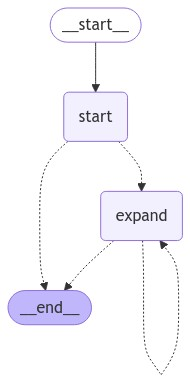

In [16]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

## Invoke

In [19]:
question = "Generate a table with the average size and weight, as well as the oldest recorded instance for each of the top 5 most common birds."
last_step = None
for step in graph.stream({"input": question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")

start
rolled out:  1
---
expand
rolled out:  2
---


In [23]:
solution_node = last_step["expand"]["root"].get_best_solution()
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

Based on the search results, here is a summary of the top 5 most common birds, their average size and weight, and the oldest recorded instances:

### Most Common Birds
1. **House Sparrow (Passer domesticus)**
   - **Average Size**: 16 cm (6.3 in)
   - **Average Weight**: 24-39 grams
   - **Oldest Recorded Instance**: Approximately 13 years

2. **European Starling (Sturnus vulgaris)**
   - **Average Size**: 20 cm (8 in)
   - **Average Weight**: 75-90 grams
   - **Oldest Recorded Instance**: 15 years

3. **Ring-billed Gull (Larus delawarensis)**
   - **Average Size**: 49 cm (19 in)
   - **Average Weight**: 300-500 grams
   - **Oldest Recorded Instance**: 23 years

4. **Barn Swallow (Hirundo rustica)**
   - **Average Size**: 15-20 cm (5.9-7.9 in)
   - **Average Weight**: 17-20 grams
   - **Oldest Recorded Instance**: 11 years

5. **Red-billed Quelea (Quelea quelea)**
   - **Average Size**: 12-13 cm (4.7-5.1 in)
   - **Average Weight**: 15-20 grams
   - **Oldest Recorded Instance**: 17 yea

In [24]:
question = "Write out magnus carlson series of moves in his game against Alireza Firouzja and propose an alternate strategy"
last_step = None
for step in graph.stream({"input": question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")

start
rolled out:  1
---
expand
rolled out:  2
---
expand
rolled out:  3
---


In [25]:
solution_node = last_step["expand"]["root"].get_best_solution()
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

To propose an alternate strategy for Magnus Carlsen in a game against Alireza Firouzja, especially if Firouzja opts for the b3 Sicilian system, let's consider the typical play and counterplay options against this opening.

### Overview of the b3 Sicilian
The b3 Sicilian is a rare but strategically rich system where White aims to fianchetto the queen's bishop and gain control over the central squares indirectly. The typical moves might start with:
1. e4 c5
2. Nf3 d6
3. Bb2

### Potential Strategy and Counterplay for Magnus Carlsen

1. **Solid Development**:
   - **1...e5**: Aiming for control of the center and developing pieces efficiently.
   - **2...Nc6**: Developing the knight to a natural square, attacking the e5 pawn and preparing to bring out other pieces.

2. **Control the Center**:
   - **3...Nf6**: Attacking the e4 pawn and preparing to develop the other knight.
   - **4...d5**: If allowed, striking the center with the d5 pawn to challenge White's setup.

3. **Flexible Pawn Str

## Conclusion

Congrats on implementing LATS! This is a technique that can be reasonably fast and effective at solving complex reasoning tasks. A few notes that you probably observed above:
1. While effective , the tree rollout can take additional compute time. If you wanted to include this in a production app, you'd either want to ensure that intermediate steps are streamed (so the user sees the thinking process/has access to intermediate results) or use it for fine-tuning data to improve the single-shot accuracy and avoid long rollouts.
2. The candidate selection process is only as good as the reward you generate. Here we are using self-reflection exclusively, but if you have an external source of feedback (such as code test execution), that should be incorporated in the locations mentioned above.